In [1]:
import sys, os, pickle
import torch
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 1
macro_configs = config_generator(g_eff=[2, 2.5, 5, 10],
                                 q_eff=[])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [21]:
#Network size
N = 2000
#Random connectivity
g = params['g_eff']
q = params['q_eff']
U = np.random.normal(0, 1/np.sqrt(N), (N, N))
S_power = 1/np.arange(1 + c*N, 1 + ((c+1)*N))**alpha
#S_line = np.diag(1 - np.arange(N)/N)
g_correction = np.sqrt(N / np.sum(S_power**2))
VT = np.random.normal(0, 1/np.sqrt(N), (N, N))
W = g_correction * g * U.dot(np.diag(S_power)).dot(VT)
#if params['somp'] and True:
W_somp = g * np.random.normal(0, 1/np.sqrt(N), (N, N))

In [ ]:
N = 2000
#Random connectivity
g = params['g_eff']
q = params['q_eff']
U = np.random.normal(0, 1/np.sqrt(N), (N, N))
S = 
g_correction = np.sqrt(N / np.sum(S**2))
VT = np.random.normal(0, 1/np.sqrt(N), (N, N))
W = g_correction * g * U.dot(np.diag(S_power)).dot(VT)
#if params['somp'] and True:
W_somp = g * np.random.normal(0, 1/np.sqrt(N), (N, N))

In [22]:
phi_numpy = lambda x: erf((np.sqrt(np.pi)/2)*x)
phi_torch = lambda x: torch.erf((np.sqrt(np.pi)/2)*x)
phi_prime = lambda x: np.exp(-(np.pi/4)*x**2)
def run_sim(T_sim, T_eval, dt, W, N_batch=1):
    device = W.device
    N = W.shape[0]
    eval_iter = int(T_eval / dt)
    Nt = int(T_sim / dt)
    N_save = int(T_sim / T_eval)
    #define stuff
    x_save = torch.zeros(N_save, N_batch, N, device=device)
    x = torch.randn(N_batch, N, device=device) * torch.std(W).item() * np.sqrt(N)
    x_save[0] = x
    r_lpf = x.clone()
    r_lpf_save = torch.zeros_like(x_save)
    r_lpf_save[0] = r_lpf
    #run
    for i in range(1, Nt):
        r = phi_torch(x)
        r_lpf += dt*(-r_lpf + r)
        x += dt*(-x + torch.mm(r, W.T)) + torch.randn(size=r.shape, device=device)*np.sqrt(dt)
        if i % eval_iter == 0:
            x_save[i//eval_iter] = x
            r_lpf_save[i//eval_iter] = r_lpf
    return x_save, r_lpf_save

In [23]:
W_ = torch.from_numpy(W_somp).type(torch.FloatTensor).to(0)
dt = 0.05
dt_save = 0.05
x_save, r_lpf_save = run_sim(4000, dt_save, dt, W_)

In [24]:
T_initial = 100
x = x_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
psi_emp = phi_prime(x).mean(1)
phi_lpf = r_lpf_save[int(T_initial/dt_save):].cpu().detach().numpy().squeeze()
Delta_emp = np.fft.irfft((np.abs(np.fft.rfft(x, axis=0, norm='ortho'))**2).mean(1))

In [29]:
r = phi_numpy(x)

In [ ]:
#cov = r.T.dot(r)/(r.shape[0] - 1)

In [ ]:
#eigs, vecs = np.linalg.eig(cov)

In [ ]:
#plt.plot(sorted(np.abs(eigs))[::-1], '.', markersize=1)
#plt.plot(np.diag(S), '.', markersize=1)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('dim idx')
#plt.ylabel('Log var explained')

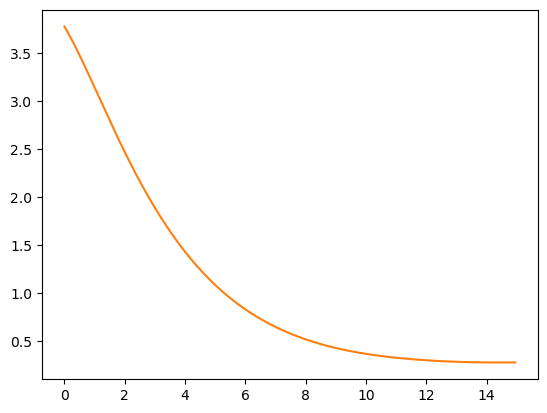

In [30]:
#time_emp = np.arange(0, 15, dt_save)
#plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1')

In [ ]:
#spec = np.array(sorted(eigs)[::-1])
#processed_data = np.array([spec, S_power/S_power[0], S])
processed_data = Delta_emp

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': None, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [29]:
###Truncate file above
file_name = 'power_decay_clean'
job_name = 'usv_autocov_3'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook power_decay_clean.ipynb to script
[NbConvertApp] Writing 6686 bytes to power_decay_clean.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ab20f721910> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ab20f721910> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [30]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=1, n_gpus=1)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
submit_job(job_script_path, n_jobs, execute=False)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/usv_autocov_3/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupyter_notebook.py
mft-theory/cluster/process_results.py
mft-theory/cluster/start_jupyter_notebook.py
mft-theory/cluster/submit_jobs.py
mft-theory/cluster/sync_cluster.py
mft-theory/core/
mft-theory/core/Simulation.py
mft-theory/core/Time_Cts_RNN.py
mft-theory/core/__init__.p

In [ ]:
job_id_1 = submit_job(job_script_path, n_jobs)

In [43]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           2849425    lkumar  jupyter   om2382  R      36:36      1 ax15


In [19]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'usv_autocov_3'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [3]:
!ls -t ../job_scripts/

usv_autocov_3.s			  s_g_spectrum_decouple.s
usv_spec_S.s			  s_g_spectrum_no_decouple.s
usv_autocov_2.s			  s_g_alignment_grid_decouple.s
usv_spec_2.s			  s_g_alignment_grid_no_decouple.s
usv_spec.s			  s_vary_alignment_nm_decouple_full.s
usv_power_expl_2.s		  s_vary_alignment_nm_decouple.s
usv_power_expl.s		  s_vary_alignment.s
prv_sample_scaling_more_T.s	  s_g_4_k.s
prv_sample_scaling.s		  s_g_small_range_k_2.s
spectrum_N_sample_scaling.s	  s_g_small_range_k.s
spectrum_N_scaling_2.s		  s_g_dim_no_subtract_big_data.s
spectrum_N_scaling.s		  s_g_dim_no_subtract.s
spectra_scaling_N_2.s		  s_g_dim.s
R_shift_spectral_decays.s	  cov_stats_s_N.s
g_spectral_decays_2.s		  cov_dist_s_N.s
g_spectral_decays.s		  k_traj_vary_s_N.s
spectra_scaling_N.s		  cov_spectra_vary_s_N.s
spectra_scaling.s		  cov_spectra_vary_s.s
pr_check_fuzzy_donut_3.s	  proj_out_m1m2_smallN.s
pr_check_fuzzy_donut_2.s	  donut_N_vary_more_data.s
pr_check_fuzzy_donut.s		  donut_N_vary.s
g_s_ratio_check.s		  reliable_donut.s
n

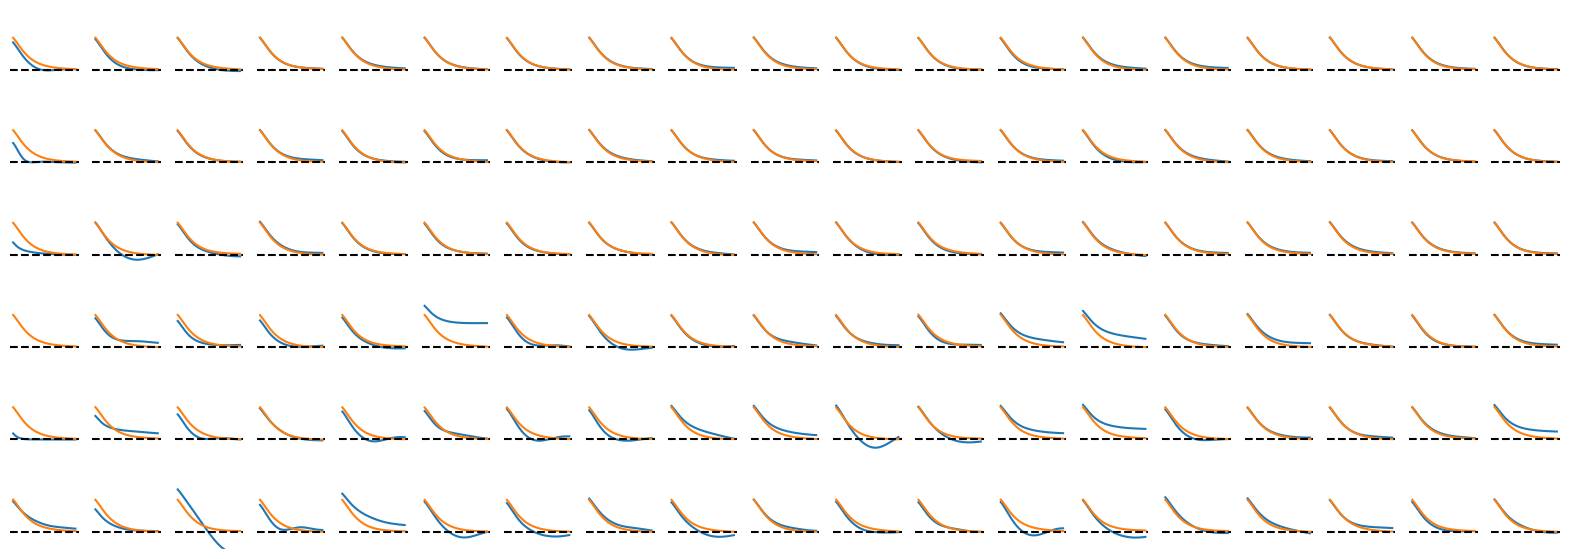

In [27]:
time_emp = np.arange(0, 15, 0.05)
fig, ax = plt.subplots(6, 19, figsize=(20,7))
for i in range(6):
    for j in range(19):
        ax[i,j].plot(time_emp, results_array[i,j,0,0,:len(time_emp)])
        ax[i,j].plot(time_emp, results_array[i,j,1,0,:len(time_emp)])
        ax[i,j].set_ylim([-2, 7])
        ax[i,j].axhline(y=0, color='k', linestyle='--')
        ax[i,j].axis('off')

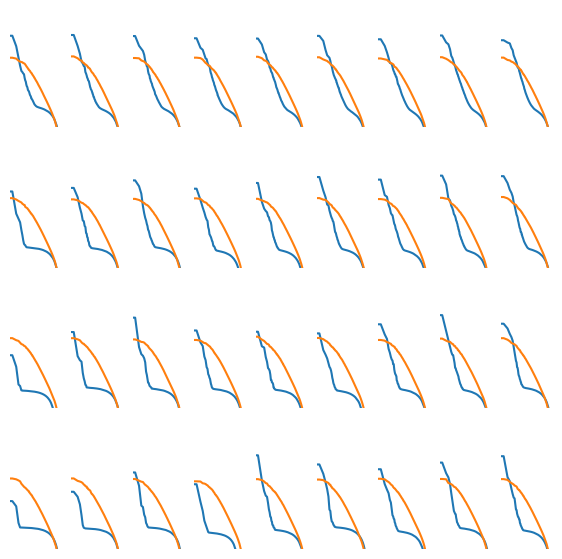

In [9]:
fig, ax = plt.subplots(4, 9, figsize=(7,7))
for i in range(4):
    for j in range(9):
        ax[i,j].plot(results_array[i,j,0,0,:])
        ax[i,j].plot(results_array[i,j,1,0,:])
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([0.1, 3000])

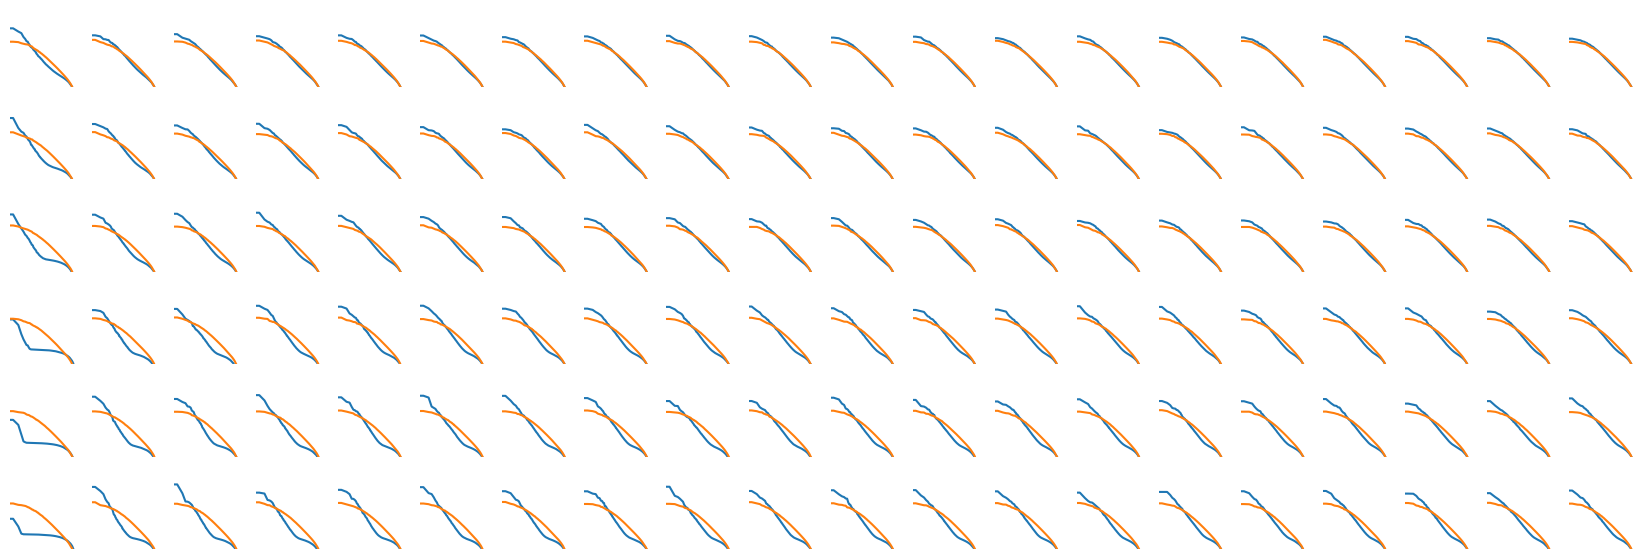

In [12]:
fig, ax = plt.subplots(6, 20, figsize=(21,7))
for i in range(6):
    for j in range(20):
        ax[i,j].plot(results_array[i,j,0,0,:])
        ax[i,j].plot(results_array[i,j,1,0,:])
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([0.1, 3000])

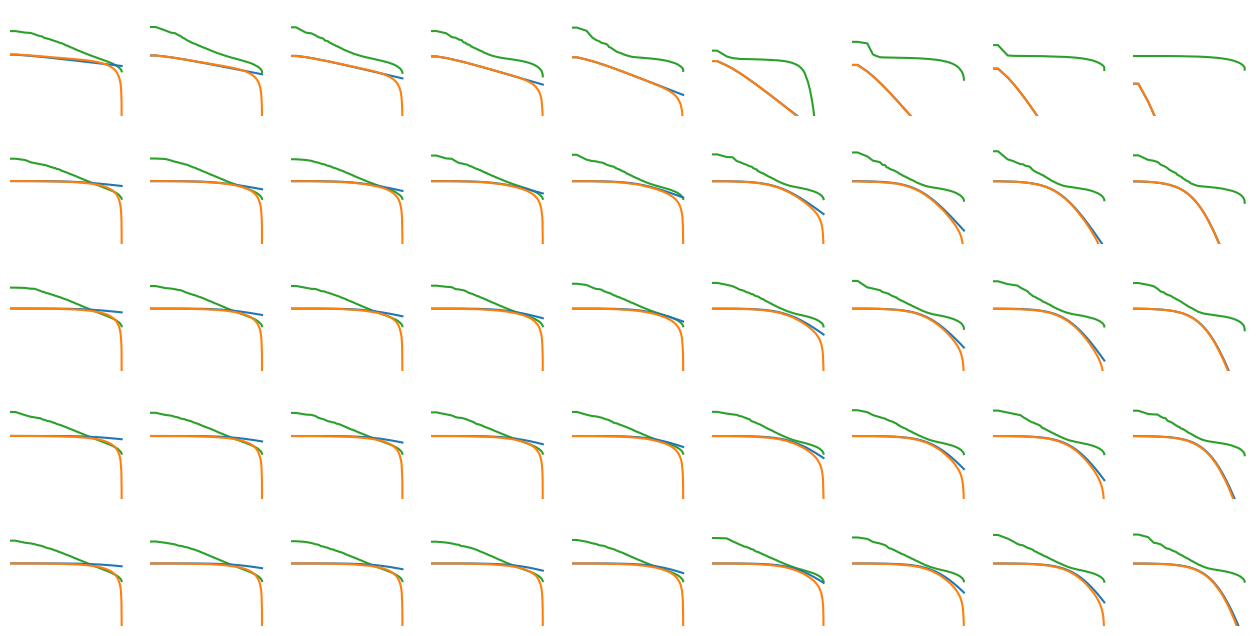

In [18]:
fig, ax = plt.subplots(5, 9, figsize=(16,8))
for i in range(5):
    for j in range(9):
        ax[i,j].plot(results_array[j,i,0,0,:], color='C2')
        ax[i,j].plot(results_array[j,i,0,1,:], color='C0')
        ax[i,j].plot(results_array[j,i,0,2,:]/results_array[j,i,0,2,0], color='C1')
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([0.00001, 3000])
fig.savefig('figs/spectra_usv_S_sing.pdf')

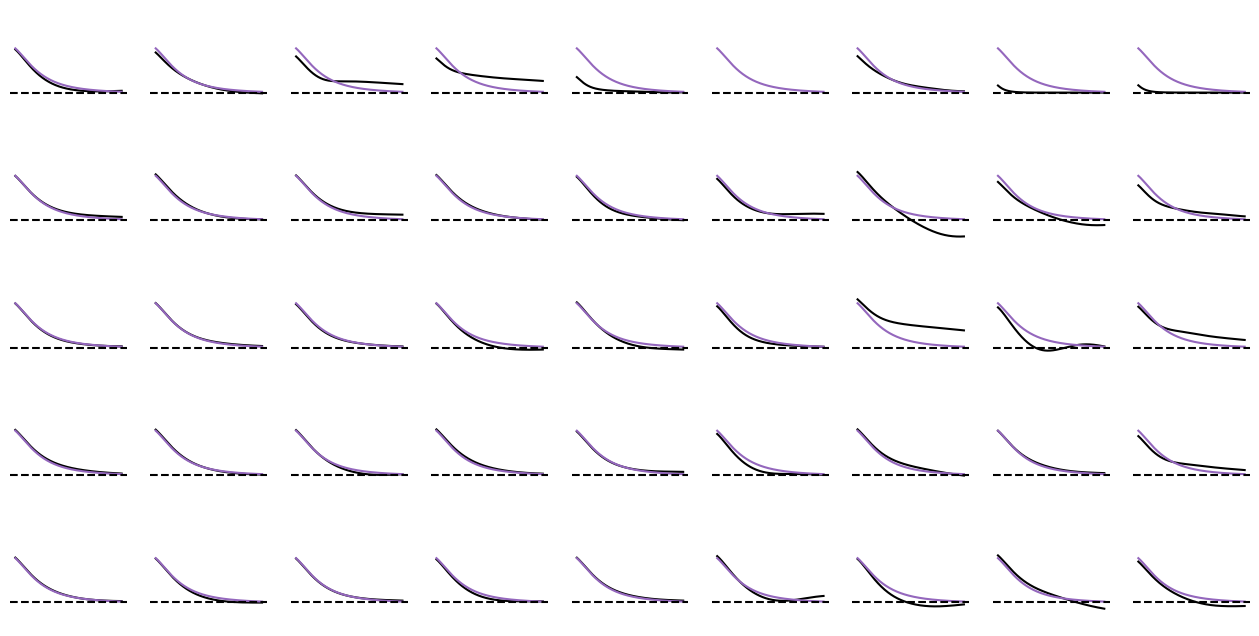

In [26]:
fig, ax = plt.subplots(5, 9, figsize=(16,8))
time_emp = np.arange(0, 15, 0.05)

for i in range(5):
    for j in range(9):
        ax[i,j].plot(time_emp, results_array[j,i,0,:len(time_emp)], color='k')
        ax[i,j].plot(time_emp, Delta_emp[:len(time_emp)], color='C4')
        #ax[i,j].set_xscale('log')
        #ax[i,j].set_yscale('log')
        ax[i,j].axis('off')
        ax[i,j].set_ylim([-2, 7])
        ax[i,j].axhline(y=0, color='k', linestyle='--')
        #ax[i,j].set_ylim([0.00001, 3000])
fig.savefig('figs/autocov_usv_S_sing.pdf')

In [20]:
results_array.shape

(9, 5, 1, 3, 2000)

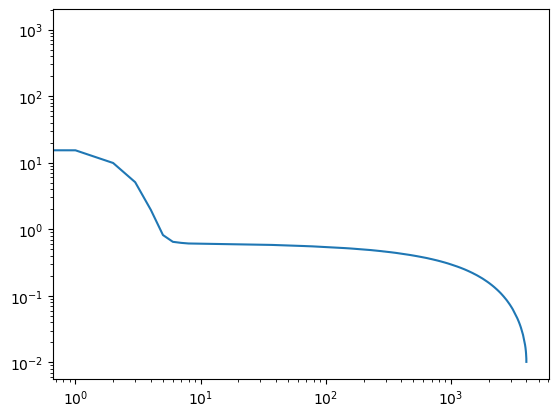

In [63]:
plt.plot(results_array[-1, 1,0,0,:])
plt.xscale('log')
plt.yscale('log')